# Deep Learning Project - A.A. 2022/2023

Students:
- Matteo Beatrice
- Luca Cotti

In this notebook we develop a CycleGAN architecture to convert photos to a Monet-like style, as a submission to the [I'm Something of a Painter Myself](https://www.kaggle.com/c/gan-getting-started) Kaggle competition.

## Initial Setup


### Model Parameters

In [ ]:
HEIGHT = 256 # Height of images
WIDTH = 256 # Width of images
CHANNELS = 3 # Number of channels of images (RGB => 3 channles)
HEIGHT_RESIZE = 128 # Height of image crop augmentation
WIDTH_RESIZE = 128 # Width of image crop augmentation

TRANSFORMER_BLOCKS = 6 # Number of transformer blocks in CycleGAN model
BATCH_SIZE = 16
EPOCHS = 5
LAMBDA_ID=1e-5
LAMBDA=10
GAMMA=1e-4
LAMBDA_START = 3
LAMBDA_END = 1e-4
GAMMA_START = 1e-4
GAMMA_END = 0.999

UPLOAD_MODEL = False

USE_BETTER_CYCLES = True # Whether to use better CycleGAN cycles or not
USE_UNET = True # Whether to use UNET CycleGAN model instead of the basic one
USE_DIFF_AUGMENT = True # Whether to use DiffAugment

MODEL_FILE_NAME = "dl_beatrice_cotti.keras"
CHECKPOINT_FILE_NAME = "dl_beatrice_cotti_cp.ckpt"

### Import Packages

Let's begin by identifying if the notebook is running on Colab.

In [ ]:
import os
IS_COLAB = os.getenv("COLAB_RELEASE_TAG") is not None


The following packages need to be downloaded on Google Colab:
- `kaggle`: to download the kaggle competition, and create a submission.
- `tensorflow-addons`: provides `InstanceNormalization` layer.

In [ ]:
if IS_COLAB:
    %pip install -q kaggle tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import random, re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

SEED = 0

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Configure Training Strategy

GPU will be used for training, because TPU is not available on the uni computer.

Tensorflow needs to be configured to distribute training on the GPUs that are available. On Colab at most one GPU will be available, but on the uni computer there should be two.

Read the [distributed training documentation](https://www.tensorflow.org/guide/distributed_training) for more info on strategies.

In [ ]:
try:
    print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

    # Uncomment this line to debug the device on which tensors are allocated
    # tf.debugging.set_log_device_placement(True)

    gpus = tf.config.list_logical_devices('GPU')

    # MirroredStrategy creates a copy of the model on each GPU,
    # splitting the input data between them.
    # If there is only one GPU, only one model will be created.
    strategy = tf.distribute.MirroredStrategy(gpus)
except:
    # Fallback if there is no GPU available
    strategy = tf.distribute.get_strategy()

# Should be equal to the number of available gpus (or 1 if no GPU available)
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of GPUs available:  1
Number of replicas: 1


### Load Dataset

Download the competition dataset in the `gan-getting-started` directory.

The import the dataset from kaggle, you need to:

1.   Create a Kaggle account
2.   Go to your Kaggle account page
3.   Scroll to API section
4.   Click `Expire API Token` to remove previous tokens
5.   Click on `Create New API Token` - It will download `kaggle.json`  file on your machine.
6.   Upload `kaggle.json` to your Google Drive if the notebook is running on Google Colab, otherwise add it to ~/.kaggle/ on your machine.

In [ ]:
!mkdir ~/.kaggle

if IS_COLAB:
    # Mount drive dir
    from google.colab import drive
    drive.mount('/content/drive')

    # Move API key file to ~/.kaggle dir
    # TODO: change this so the key is not left in the home dir of the uni computer
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c gan-getting-started
!rm -r gan-getting-started # Remove dir if it already exists
!mkdir gan-getting-started
!unzip -qq gan-getting-started.zip -d gan-getting-started
!rm gan-getting-started.zip

DATASET_PATH = "gan-getting-started"

Mounted at /content/drive
 96% 353M/367M [00:05<00:00, 67.6MB/s]
100% 367M/367M [00:05<00:00, 68.9MB/s]
rm: cannot remove 'gan-getting-started': No such file or directory


Check the number of TFRecords and of actual image files.

In [ ]:
# Load the filenames of the TFRecords
MONET_FILENAMES = tf.io.gfile.glob(str(DATASET_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(DATASET_PATH + '/photo_tfrec/*.tfrec'))

# Counts the amount of data items in a TFRecord
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


### Data Augmentations

Data augmentation for GANs should be done very carefully, especially for tasks similar to style transfer. If we apply transformations that can change too much the style of the data (e.g. brightness, contrast, saturation) it can cause the generator to do not efficiently learn the base style, so in this case, we are using only spatial transformations like flips, rotations and crops.

In [ ]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    # Resize to 286x286
    image = tf.image.resize(image, [286, 286])

    # Random crop to HEIGHTxWIDTH
    image = tf.image.random_crop(image, size=[HEIGHT, WIDTH, CHANNELS])

    # Rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

Differentiable Augmentation for Data-Efficient GAN Training
Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
(https://arxiv.org/pdf/2006.10738),
from https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment_tf.py.

See https://www.kaggle.com/code/unfriendlyai/diffaugment-is-all-you-need/notebook.

In [ ]:
with strategy.scope():
    def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x


    def rand_brightness(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
        x = x + magnitude
        return x


    def rand_saturation(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
        return x


    def rand_contrast(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6
        x = (x - x_mean) * magnitude + x_mean
        return x

    def rand_translation(x, ratio=0.125):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
        translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
        grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
        grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
        x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
        x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
        return x


    def rand_cutout(x, ratio=0.5):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
        offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
        grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
        cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
        mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
        cutout_grid = tf.maximum(cutout_grid, 0)
        cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
        mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
        x = x * tf.expand_dims(mask, axis=3)
        return x


    AUGMENT_FNS = {
        'color': [rand_brightness, rand_saturation, rand_contrast],
        'translation': [rand_translation],
        'cutout': [rand_cutout],
    }

    def aug_fn(image):
        return DiffAugment(image,"color,translation,cutout")

### Utility Functions

In [ ]:
# Reads a tensor as an image.
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

# Map image values in the range [-1, 1]
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

# Reads an image from a TFRecord.
# Because we are building a generative model,
# we don't need the labels or the image id so we'll only return the image from the TFRecord.
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# Extracts the image from the TFRecord files.
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Loads the dataset and applies the selected options.
def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Let's test if the datasets loads correctly.

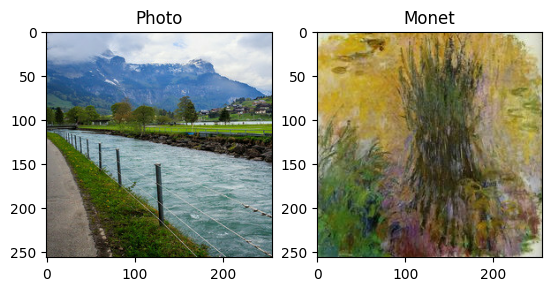

In [ ]:
monet_ds = get_dataset(MONET_FILENAMES)
photo_ds = get_dataset(PHOTO_FILENAMES)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0]* 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Model

### Basic Blocks

In [ ]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=layers.ReLU(), name='block_x'):
    block = layers.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]

    block = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False,
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
    block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = layers.ReLU()(block)

    block = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False,
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
    block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = layers.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = layers.Conv2DTranspose(filters, size,
                              strides=strides,
                              padding='same',
                              use_bias=False,
                              kernel_initializer=conv_initializer,
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = layers.ReLU()(block)

    return block

def downsample(filters, size, apply_instancenorm=True, add_noise=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if add_noise:
        result.add(layers.GaussianNoise(0.2))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Generator

In [ ]:
def BasicGenerator(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    inputs = layers.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=layers.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=layers.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=layers.ReLU(), name='block_3')   # (bs, 64, 64, 256)

    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = layers.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection

    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = layers.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection

    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = layers.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    last = layers.Conv2D(CHANNELS, 7,
                              strides=1, padding='same',
                              kernel_initializer=conv_initializer,
                              use_bias=False,
                              activation='tanh',
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)
    outputs = last

    generator = keras.Model(inputs, outputs)
    return generator

In [ ]:
def UNETGenerator(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = layers.Input(shape=[height,width,channels])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Discriminator

In [ ]:
def BasicDiscriminator(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = layers.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=layers.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=layers.LeakyReLU(0.2), name='block_2')       # (bs, 64, 64, 128)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=layers.LeakyReLU(0.2), name='block_3')       # (bs, 32, 32, 256)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=layers.LeakyReLU(0.2), name='block_4')       # (bs, 32, 32, 512)

    outputs = layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)

    discriminator = keras.Model(inputs, outputs)

    return discriminator

In [ ]:
def UNETDiscriminator(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[height, width, channels], name='input_image')

    x = inp

    down1 = downsample(64, 4, False, add_noise=True)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4, add_noise=True)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4, add_noise=True)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
    if USE_UNET:
        monet_generator = UNETGenerator() # transforms photos to Monet-esque paintings
        photo_generator = UNETGenerator() # transforms Monet paintings to be more like photos
        monet_discriminator = UNETDiscriminator() # differentiates real Monet paintings and generated Monet paintings
        photo_discriminator = UNETDiscriminator() # differentiates real photos and generated photos
    else:
        monet_generator = BasicGenerator(transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to Monet-esque paintings
        photo_generator = BasicGenerator(transformer_blocks=TRANSFORMER_BLOCKS) # transforms Monet paintings to be more like photos
        monet_discriminator = BasicDiscriminator() # differentiates real Monet paintings and generated Monet paintings
        photo_discriminator = BasicDiscriminator() # differentiates real photos and generated photos

### CycleGAN

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=LAMBDA,
        lambda_id_cycle=LAMBDA_ID,
        gamma_cycle=GAMMA,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_id_cycle = lambda_id_cycle
        self.gamma_cycle = gamma_cycle
        self.m_disc_feat = keras.Model(inputs=self.m_disc.input,
                                              outputs=self.m_disc.layers[-2].output)
        self.p_disc_feat = keras.Model(inputs=self.p_disc.input,
                                              outputs=self.p_disc.layers[-2].output)

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # DiffAugment
            both_monet = tf.concat([real_monet, fake_monet], axis=0)
            aug_monet = aug_fn(both_monet)
            aug_real_monet = aug_monet[:BATCH_SIZE]
            aug_fake_monet = aug_monet[BATCH_SIZE:]

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            if USE_BETTER_CYCLES:
                disc_feat_photo = self.p_disc_feat(real_photo, training=True)
                disc_feat_cycled_photo = self.p_disc_feat(cycled_photo, training=True)
                disc_feat_monet = self.m_disc_feat(real_monet, training=True)
                disc_feat_cycled_monet = self.m_disc_feat(cycled_monet, training=True)

                photo_cycle_loss = (self.cycle_loss_fn(real_photo, cycled_photo, 1-self.gamma_cycle) +
                                    self.cycle_loss_fn(disc_feat_photo, disc_feat_cycled_photo, self.gamma_cycle))
                monet_cycle_loss = (self.cycle_loss_fn(real_monet, cycled_monet, 1-self.gamma_cycle) +
                                    self.cycle_loss_fn(disc_feat_monet, disc_feat_cycled_monet, self.gamma_cycle))

                total_cycle_loss = self.lambda_cycle * (photo_cycle_loss + monet_cycle_loss)
            else:
                total_cycle_loss = (self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) +
                                    self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle))

            # evaluates total generator loss
            total_monet_gen_loss = (monet_gen_loss + total_cycle_loss +
                                    self.identity_loss_fn(real_monet, same_monet, self.lambda_id_cycle))
            total_photo_gen_loss = (photo_gen_loss + total_cycle_loss
                                    + self.identity_loss_fn(real_photo, same_photo, self.lambda_id_cycle))

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = keras.losses.BinaryCrossentropy(from_logits=True,
                                                       reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        real_loss = tf.reduce_mean(real_loss)

        generated_loss = keras.losses.BinaryCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        generated_loss = tf.reduce_mean(generated_loss)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        loss = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        loss = tf.reduce_mean(loss)

        return loss

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Training

### Update Loss Weights Callback

In [ ]:
class UpdateLossWeightsCallback(keras.callbacks.Callback):
    def __init__(self, epochs=EPOCHS, lambda_start=LAMBDA_START, lambda_end=LAMBDA_END, gamma_start=GAMMA_START, gamma_end=GAMMA_END):
        super().__init__()
        self.epochs = epochs
        self.lambda_start = lambda_start
        self.lambda_end = lambda_end
        self.gamma_start = gamma_start
        self.gamma_end = gamma_end

    def on_train_begin(self, logs=None):
        self.lambda_values = np.linspace(self.lambda_start, self.lambda_end, self.epochs)
        self.gamma_values = np.linspace(self.gamma_start, self.gamma_end, self.epochs)

    def on_epoch_begin(self, epoch, logs=None):
        self.model.lambda_cycle = self.lambda_values[epoch]
        self.model.gamma_cycle = self.gamma_values[epoch]

In [ ]:
with strategy.scope():
    update_weights_cb = UpdateLossWeightsCallback(
        EPOCHS,
        lambda_start=LAMBDA_START,
        lambda_end=LAMBDA_END,
        gamma_start=GAMMA_START,
        gamma_end=GAMMA_END)

### Learning Rate Schedule

The original CycleGAN implementation used a constant learning rate schedule with a linear decay, I also found that the linear decay phase seems to be good at making the model more stable at the last epochs, you can check how the generator changes in a more conservative rate by the end looking at the gif images by the end.

In [ ]:
class LinearScheduleWithWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
  """
  Creates a schedule with a learning rate that decreases linearly after
  linearly increasing during a warmup period.
  """

  def __init__(self):
    self.lr_start = 2e-4
    self.lr_max = 2e-4
    self.lr_min = 0.
    self.steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
    self.warmup_steps = 10
    self.total_steps = EPOCHS * self.steps_per_epoch
    self.hold_max_steps = self.total_steps * 0.8

  @tf.function # Decorator needed to convert python if/else/boolean conditions to tensor ops
  def __call__(self, step):
    # step is an int tensor, which needs to be converted to float
    step = tf.cast(step, tf.float32)

    if step < self.warmup_steps:
      return (self.lr_max - self.lr_start) / self.warmup_steps * step + self.lr_start
    elif step < self.warmup_steps + self.hold_max_steps:
      return self.lr_max
    else:
      lr = self.lr_max * ((self.total_steps - step) / (self.total_steps - self.warmup_steps - self.hold_max_steps))
      if self.lr_min is not None:
        lr = tf.math.maximum(self.lr_min, lr)
      return lr

### Optimizers

In [ ]:
with strategy.scope():
    # Create generators
    monet_generator_optimizer = tf.optimizers.Adam(learning_rate=LinearScheduleWithWarmup(), beta_1=0.5)
    photo_generator_optimizer = tf.optimizers.Adam(learning_rate=LinearScheduleWithWarmup(), beta_1=0.5)

    # Create discriminators
    monet_discriminator_optimizer = tf.optimizers.Adam(learning_rate=LinearScheduleWithWarmup(), beta_1=0.5)
    photo_discriminator_optimizer = tf.optimizers.Adam(learning_rate=LinearScheduleWithWarmup(), beta_1=0.5)

### Create Datasets

In [ ]:
monet_ds = get_dataset(MONET_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

photo_ds_eval = get_dataset(PHOTO_FILENAMES, repeat=False, shuffle=False, batch_size=1)
monet_ds_eval = get_dataset(MONET_FILENAMES, repeat=False, shuffle=False, batch_size=1)

### Launch Training

In [ ]:
# Create GAN
with strategy.scope():
  gan_model = CycleGan(monet_generator, photo_generator,
                          monet_discriminator, photo_discriminator)

  gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                    p_gen_optimizer=photo_generator_optimizer,
                    m_disc_optimizer=monet_discriminator_optimizer,
                    p_disc_optimizer=photo_discriminator_optimizer,
                    gen_loss_fn=generator_loss,
                    disc_loss_fn=discriminator_loss,
                    cycle_loss_fn=calc_cycle_loss,
                    identity_loss_fn=identity_loss)

  callbacks=[]

  if USE_BETTER_CYCLES:
    callbacks.append(update_weights_cb)

history = gan_model.fit(gan_ds,
                        epochs=EPOCHS,
                        steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE),
                        callbacks=callbacks
                        ).history

Epoch 1/2
 89/439 [=====>........................] - ETA: 18:14 - monet_gen_loss: 2.1727 - photo_gen_loss: 2.1732 - monet_disc_loss: 0.6932 - photo_disc_loss: 0.6923

KeyboardInterrupt: ignored

## Results

### Display Converted Photos

In [ ]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)

        f = plt.figure(figsize=(12, 12))

        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

display_generated_samples(photo_ds_eval.take(8), monet_generator, 8)

### Save Model

In [ ]:
gan_model.save(MODEL_FILE_NAME)

if IS_COLAB:
    from google.colab import files
    files.download(MODEL_FILE_NAME)